In [227]:
import json
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans


import numpy as np

%matplotlib inline

theses = '../data/theses_dump_06-04-2017'
collections = '../data/collections_dump_21-03-2017.json'

def jl_to_df(fname):
    with open(fname) as f:
        return pd.DataFrame([json.loads(line) for line in f])

In [228]:
collections = jl_to_df(collections)
theses = jl_to_df(theses)

# Create university MongoDB collection data

In [229]:
collections.head()

,_id,name
0,com_10024_1,Seinäjoen ammattikorkeakoulu
1,com_10024_4,Yrkeshögskolan Arcada
2,com_10024_5,Jyväskylän ammattikorkeakoulu
3,com_10024_6,Metropolia Ammattikorkeakoulu
4,com_10024_10,Lahden ammattikorkeakoulu


In [230]:
universities = collections[collections['_id'].apply(lambda x: 'com' in x)]

In [231]:
universities

,_id,name
0,com_10024_1,Seinäjoen ammattikorkeakoulu
1,com_10024_4,Yrkeshögskolan Arcada
2,com_10024_5,Jyväskylän ammattikorkeakoulu
3,com_10024_6,Metropolia Ammattikorkeakoulu
4,com_10024_10,Lahden ammattikorkeakoulu
5,com_10024_12,Laurea-ammattikorkeakoulu
6,com_10024_13,Tampereen ammattikorkeakoulu
7,com_10024_14,Satakunnan ammattikorkeakoulu
8,com_10024_15,Turun ammattikorkeakoulu
9,com_10024_431,Haaga-Helia ammattikorkeakoulu


In [232]:
# TODO: handle duplicate codes for Lapin Ammartikorkeakoulu
universities[universities['_id'] != 'com_10024_6241'].to_json("universities.json", orient="records")

# Create degree MongoDB collection data

In [233]:
university_ids = theses['collections'].apply(lambda xs: [x for x in xs if 'com' in x])
degree_ids = theses['collections'].apply(lambda xs: [x for x in xs if 'col' in x])

print("Theses with not 1 university:")
print(university_ids[university_ids.apply(len) != 1])
print("Theses with not 1 degree:")
print(degree_ids[degree_ids.apply(len) != 1])

# We only take the first id we find for universities and degrees
theses['university_id'] = university_ids.apply(lambda xs: xs[0] if len(xs) > 0 else '')
theses['degree_id'] = degree_ids.apply(lambda xs: xs[0] if len(xs) > 0 else '')

Theses with not 1 university:
Series([], Name: collections, dtype: object)
Theses with not 1 degree:
1835                        [col_10024_269, col_10024_279]
3071      [col_10024_1556, col_10024_1556, col_10024_1556]
5189                      [col_10024_1907, col_10024_1929]
5517                      [col_10024_1663, col_10024_1663]
9318                      [col_10024_1906, col_10024_1909]
24893                       [col_10024_161, col_10024_161]
40207                     [col_10024_79818, col_10024_397]
101348                    [col_10024_2157, col_10024_2157]
103566                  [col_10024_77341, col_10024_77341]
103573                      [col_10024_135, col_10024_135]
113167                      [col_10024_125, col_10024_125]
Name: collections, dtype: object


## Get list of topics for each degree

In [234]:
degree_topics = pd.DataFrame(
    theses.groupby(["degree_id"])["topics"].sum(),
    columns=["topics"]
).reset_index()
degree_topics['n_theses'] = theses.groupby(["degree_id"]).size().values
degree_topics.head()

,degree_id,topics,n_theses
0,col_10024_100,"[lääkehoito, development project, implementati...",46
1,col_10024_100099,"[produktion, tga, biodegradable plastics, star...",1
2,col_10024_100100,"[non-technical skills, caracters and character...",4
3,col_10024_101,"[ammattitaito, konepajat, työssäoppiminen, aik...",228
4,col_10024_102,"[arviointitutkimus, tietokoneen käyttö, käytet...",35


## Generate topics collection data

In [235]:
topics_df = pd.DataFrame()
topics_df["_id"] = list(set(degree_topics["topics"].sum()))

topics_count = pd.Series(degree_topics["topics"].sum()).value_counts()
topics_df = pd.DataFrame({"_id": topics_count.index, "count": topics_count.values})

# People have used ; or - or . or " " as separators for topics instead of ,
topics_df[topics_df["_id"].apply(len) > 50]

topics_df[topics_df["_id"].apply(len) < 50].to_json("topics.json", orient="records")

## Get matrix representation of topics by degree

In [236]:
len(topics_count[topics_count > 1])
# NOTE: possible bug on sklearn, as 45353 does not match with len(cv.get_feature_names()) = 41848

45353

In [237]:
cv = CountVectorizer(
    tokenizer=lambda token: token,
    lowercase=False, min_df=2
)
M = cv.fit_transform(degree_topics["topics"].values)
M

<1026x41848 sparse matrix of type '<type 'numpy.int64'>'
	with 337320 stored elements in Compressed Sparse Row format>

In [238]:
len(cv.get_feature_names())

41848

## Do TFIDF

Tfid was proven to be important, because without it most popular degrees (liiketalouden) will lie apart, and not within a cluesr

In [239]:
M = TfidfTransformer().fit_transform(M)

In [240]:
M

<1026x41848 sparse matrix of type '<type 'numpy.float64'>'
	with 337320 stored elements in Compressed Sparse Row format>

In [241]:
M.max()

1.0

## Plot degrees on two coordinates using PCA

In [242]:
pca = PCA(n_components=200)
pca_projection = pca.fit_transform(M.toarray())

In [243]:
pca_projection.shape

(1026, 200)

[]

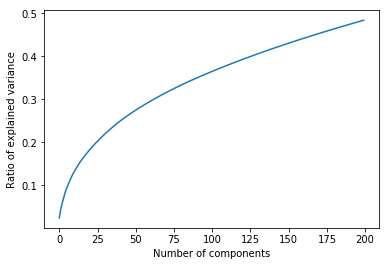

In [244]:
explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(explained_variance)
#plt.title("Ratio of explained variance by number of components")
plt.xlabel("Number of components")
plt.ylabel("Ratio of explained variance")
plt.plot()

In [245]:
explained_variance[1]

0.04526073015121964

In [246]:
pd.Series(explained_variance > 0.99).value_counts()

False    200
dtype: int64

The two principal components explains less than 5% of the variance. It is required to use 953 components to get more thann 99% of the variance explained

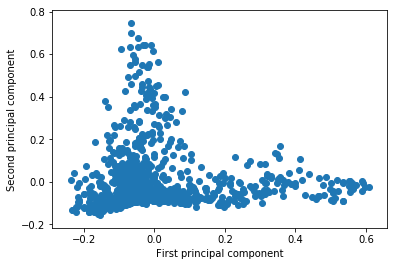

In [247]:
# Plotting the projection in 2-dimensions of each degree
plt.scatter(pca_projection[:, 0], pca_projection[:, 1])
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [248]:
pca_projection.shape

(1026, 200)

## Get x, y coordinates for each degree

TSNE results vary between runs, should write about how to detect a good result, and the conditions for convergence.

It is highly recommended to use another dimensionality reduction
method (e.g. PCA for dense data or TruncatedSVD for sparse data)
to reduce the number of dimensions to a reasonable amount (e.g. 50)
if the number of features is very high. This will suppress some
noise and speed up the computation of pairwise distances between
samples. For more tips see Laurens van der Maaten's FAQ [2].

Should consider whether removing degrees that haveless than certain number of thesis offers better performance for tsne.

In [249]:
# TSNE with cosine distance
#cosine_d = pairwise_distances(pca_projection, metric='cosine')
# Due to round up errors some distances are < 0 and that poses erros on tsne so we cap them to zero.
#cap_to_zero = np.vectorize(lambda x: 0 if x < 0 else x)
#cosine_d = cap_to_zero(cosine_d)
#tsne = TSNE(perplexity=200, metric="precomputed")
#tsne.fit_transform(cosine_d)

In [250]:
tsne = TSNE(perplexity=30)
tsne.fit_transform(pca_projection)

array([[ -4.80348271,  -8.12205834],
       [-25.61770047,  19.8375793 ],
       [-23.11723659,  22.23038799],
       ..., 
       [-25.50811659,  20.80245139],
       [-20.04552289,   8.19050316],
       [-10.69003315,  13.8612229 ]])

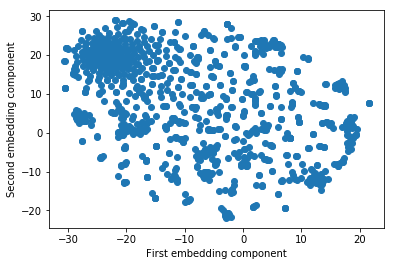

In [251]:
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1])
plt.xlabel("First embedding component")
plt.ylabel("Second embedding component")

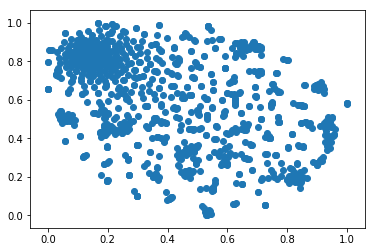

In [252]:
mms = MinMaxScaler()
embeddings = mms.fit_transform(tsne.embedding_)
plt.scatter(embeddings[:, 0], embeddings[:, 1])

In [253]:
embeddings.shape

(1026, 2)

In [254]:
degree_topics.shape

(1026, 3)

In [255]:
# Add x, y coordinates
degree_topics['x'] = embeddings[:, 0]
degree_topics['y'] = embeddings[:, 1]

# Add total number of topics for each degree
degree_topics['n_topics'] = degree_topics['topics'].apply(len)

# Add university_id, university_name, degree_name
# NOTE: there is no degree id in degrees_topics that does not appear in collections
collection_university_map = pd.DataFrame(theses.groupby(["degree_id", "university_id"]).groups.keys(), columns=["degree_id", "university_id"])
degree_topics = degree_topics.merge(collections.rename(columns={'_id': 'degree_id', 'name': 'degree_name'}), how="left")
degree_topics = degree_topics.merge(collection_university_map, how="left")
degree_topics = degree_topics.merge(collections.rename(columns={'_id': 'university_id', 'name': 'university_name'}), how="left")

In [256]:
degree_topics

,degree_id,topics,n_theses,x,y,n_topics,degree_name,university_id,university_name
0,col_10024_100,"[lääkehoito, development project, implementati...",46,0.494701,0.271152,292,Sosiaali- ja terveysalan kliininen asiantuntij...,com_10024_15,Turun ammattikorkeakoulu
1,col_10024_100099,"[produktion, tga, biodegradable plastics, star...",1,0.095570,0.820915,10,Degree Programme in Materials Processing Techn...,com_10024_4,Yrkeshögskolan Arcada
2,col_10024_100100,"[non-technical skills, caracters and character...",4,0.143518,0.867964,41,"Degree Programme in Global Health Care, högre YH",com_10024_4,Yrkeshögskolan Arcada
3,col_10024_101,"[ammattitaito, konepajat, työssäoppiminen, aik...",228,0.599515,0.265017,1276,Kone- ja tuotantotekniikka,com_10024_15,Turun ammattikorkeakoulu
4,col_10024_102,"[arviointitutkimus, tietokoneen käyttö, käytet...",35,0.447963,0.926576,205,Kuntoutus (ylempi AMK),com_10024_15,Turun ammattikorkeakoulu
5,col_10024_102390,"[kampanjer, yrkeshögskolebibliotek, motion]",2,0.093655,0.866471,3,AAAaaafi=Parallel Publications|,com_10024_4,Yrkeshögskolan Arcada
6,col_10024_103,"[omaelämäkerrallisuus, omakuvat, elämäkerrat, ...",66,0.263101,0.611811,396,Kuvataide,com_10024_15,Turun ammattikorkeakoulu
7,col_10024_103494,"[stress, international degree nursing student,...",17,0.689470,0.747755,122,Degree Programme in Nursing,com_10024_10,Lahden ammattikorkeakoulu
8,col_10024_104,"[lääkkeet, epäpuhtaudet, ich, rekisteröinti, s...",15,0.739823,0.643780,116,Laboratorioala,com_10024_15,Turun ammattikorkeakoulu
9,col_10024_104104,"[työnohjaus, dialogisuus, kehittäminen, johtam...",9,0.586330,0.514662,39,AAAAaaafi=Diak työelämä|,com_10024_1552,Diakonia-ammattikorkeakoulu


(1, 2427)


[]

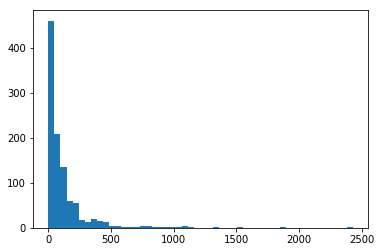

In [257]:
plt.hist(degree_topics['n_theses'], bins=50)
min_count = min(degree_topics['n_theses'])
max_count = max(degree_topics['n_theses'])
print(min_count, max_count)
plt.plot()

(0, 15347)


[]

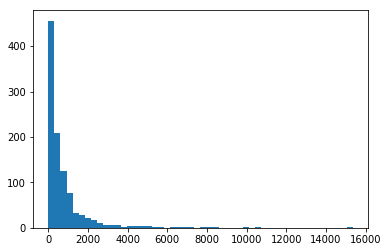

In [258]:
plt.hist(degree_topics['n_topics'], bins=50)
min_count = min(degree_topics['n_topics'])
max_count = max(degree_topics['n_topics'])
print(min_count, max_count)
plt.plot()

(460, 9)
(215, 9)
(315, 9)
(32, 9)


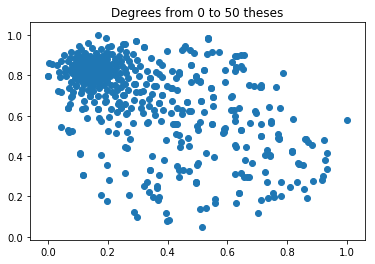

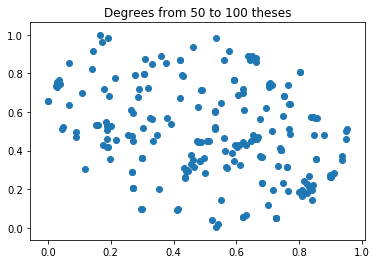

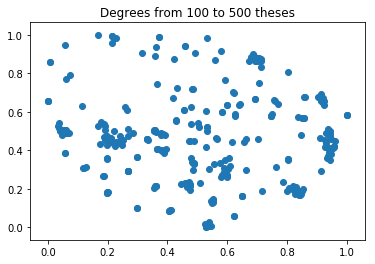

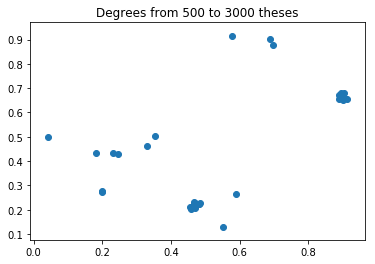

In [259]:
import itertools

THESIS_COUTNS = [0, 50, 100, 500, 3000]

def plot_scatter(field, min_count, max_count, title):
    plt.figure()
    mask = (degree_topics[field] > min_count) & (degree_topics[field] < max_count)
    most_popular = degree_topics[mask]
    print(most_popular.shape)
    plt.scatter(most_popular['x'], most_popular['y'])
    plt.title(title.format(min_count, max_count))
    plt.plot()


for min_count, max_count in zip(THESIS_COUTNS, THESIS_COUTNS[1:]):
    plot_scatter("n_theses", min_count, max_count, "Degrees from {} to {} theses")

(166, 9)
(65, 9)
(348, 9)
(225, 9)
(206, 9)


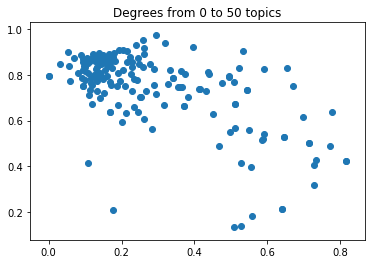

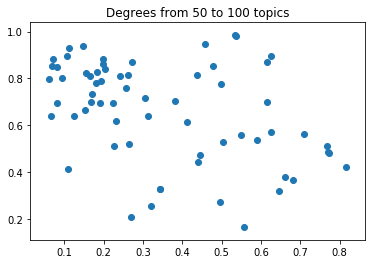

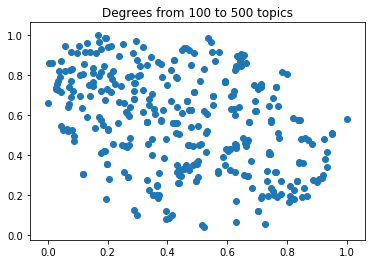

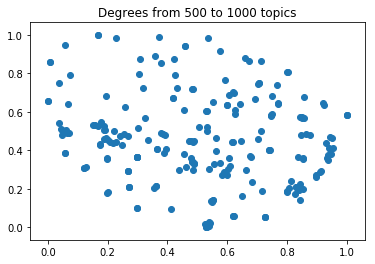

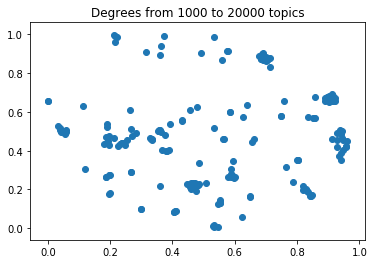

In [260]:
TOPIC_COUNTS = [0, 50, 100, 500, 1000, 20000]

for min_count, max_count in zip(TOPIC_COUNTS, TOPIC_COUNTS[1:]):
    plot_scatter("n_topics", min_count, max_count, "Degrees from {} to {} topics")

We can observe that degrees with more theses position itself in a more or less central location. Degrees with more theses, postion in the borders of the plot, to maximize the distance between them.

## k-means clustering

In [261]:
kmean = KMeans(n_clusters=10, n_init=20,)

In [262]:
kmean.fit(pca_projection)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [263]:
pd.Series(kmean.labels_).value_counts()

0    570
1     70
6     68
7     61
4     61
2     59
5     47
3     41
8     31
9     18
dtype: int64

In [264]:
degree_topics["kmeans_cluster"] = kmean.labels_

In [265]:
kmean_degrees = degree_topics[degree_topics["kmeans_cluster"] != 3]

In [266]:
def visualize_cluster(x, y, labels):
    # Visualize cluster
    cmap = plt.get_cmap('jet')
    norm = Normalize(min(labels), max(labels))
    plt.scatter(x, y, 9, cmap(norm(labels)))
    plt.xlabel("First embedding component")
    plt.ylabel("Second embedding component")
    plt.plot()

In [267]:
degree_topics[degree_topics["kmeans_cluster"] == 0]

,degree_id,topics,n_theses,x,y,n_topics,degree_name,university_id,university_name,kmeans_cluster
1,col_10024_100099,"[produktion, tga, biodegradable plastics, star...",1,0.095570,0.820915,10,Degree Programme in Materials Processing Techn...,com_10024_4,Yrkeshögskolan Arcada,0
2,col_10024_100100,"[non-technical skills, caracters and character...",4,0.143518,0.867964,41,"Degree Programme in Global Health Care, högre YH",com_10024_4,Yrkeshögskolan Arcada,0
4,col_10024_102,"[arviointitutkimus, tietokoneen käyttö, käytet...",35,0.447963,0.926576,205,Kuntoutus (ylempi AMK),com_10024_15,Turun ammattikorkeakoulu,0
5,col_10024_102390,"[kampanjer, yrkeshögskolebibliotek, motion]",2,0.093655,0.866471,3,AAAaaafi=Parallel Publications|,com_10024_4,Yrkeshögskolan Arcada,0
6,col_10024_103,"[omaelämäkerrallisuus, omakuvat, elämäkerrat, ...",66,0.263101,0.611811,396,Kuvataide,com_10024_15,Turun ammattikorkeakoulu,0
7,col_10024_103494,"[stress, international degree nursing student,...",17,0.689470,0.747755,122,Degree Programme in Nursing,com_10024_10,Lahden ammattikorkeakoulu,0
8,col_10024_104,"[lääkkeet, epäpuhtaudet, ich, rekisteröinti, s...",15,0.739823,0.643780,116,Laboratorioala,com_10024_15,Turun ammattikorkeakoulu,0
9,col_10024_104104,"[työnohjaus, dialogisuus, kehittäminen, johtam...",9,0.586330,0.514662,39,AAAAaaafi=Diak työelämä|,com_10024_1552,Diakonia-ammattikorkeakoulu,0
10,col_10024_104107,"[taidekasvatus, erityisopetus, ohjaus, kokemuk...",6,0.251748,0.702118,40,AAAAaaafi=Diak puheenvuoro|,com_10024_1552,Diakonia-ammattikorkeakoulu,0
11,col_10024_104108,"[pedagogiikka, kirkko, tutkiva oppiminen, osal...",2,0.587064,0.520688,19,AAAAaaafi=Diak opetus|,com_10024_1552,Diakonia-ammattikorkeakoulu,0


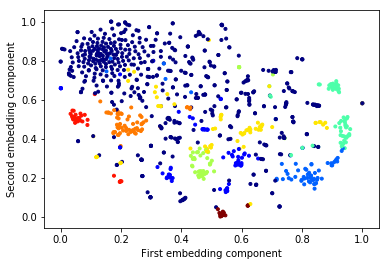

In [268]:
visualize_cluster(kmean_degrees['x'], kmean_degrees['y'], kmean_degrees['kmeans_cluster'])

## Hierarchical clustering

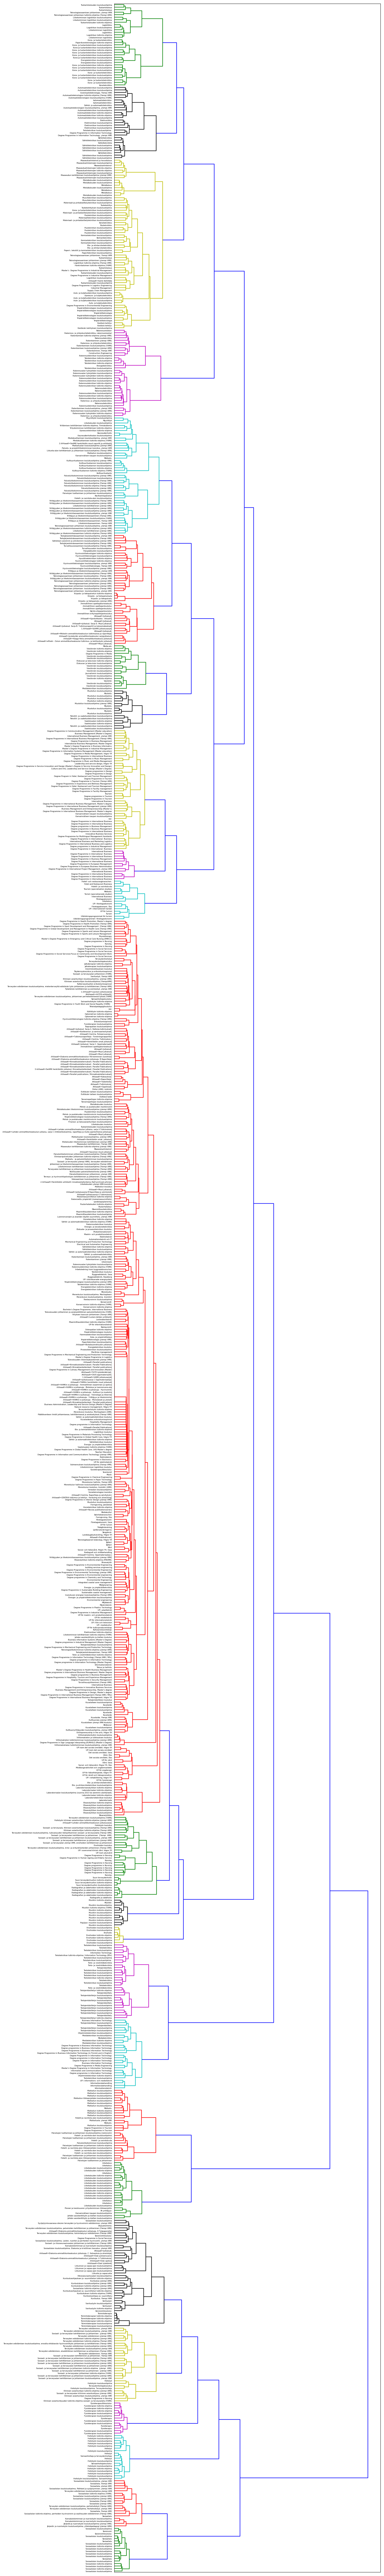

In [269]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import ward, complete, single, weighted, centroid, median, dendrogram, fcluster
#https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy
# http://brandonrose.org/clustering
# For cutting dendogram to get clusters:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

d = pairwise_distances(M, metric='cosine')
linkage_matrix = ward(d) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 100)) # set size
ax = dendrogram(linkage_matrix, color_threshold=6, orientation="right", labels=degree_topics['degree_name'].values, show_leaf_counts=True);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('hierarchy-temp.png', format='png') 

In [270]:
level1 = fcluster(linkage_matrix, 10, criterion='maxclust')
level2 = fcluster(linkage_matrix, 100, criterion='maxclust')

In [271]:
degree_topics['level1'] = level1
degree_topics['level2'] = level2

In [272]:
degree_topics.groupby(['level1', 'level2']).size().reset_index().groupby(['level1']).size()

level1
1      4
2      1
3     10
4      5
5      5
6     30
7      9
8     19
9      3
10    14
dtype: int64

In [273]:
level1_topics = degree_topics.groupby("level1")["topics"].sum()
level2_topics = degree_topics.groupby("level2")["topics"].sum()

In [274]:
def get_most_popular(topics, n=4):
    return list(pd.Series(topics).value_counts().head(n).index)

In [275]:
level1_popular_topics = pd.DataFrame(level1_topics.apply(get_most_popular)).reset_index().rename(columns={0: "level1_topics"})

In [276]:
level1_popular_topics

,level1,level1_topics
0,1,"[varhaiskasvatus, osallisuus, lastensuojelu, n..."
1,2,"[hoitotyö, terveyden edistäminen, nuoret, ohjaus]"
2,3,"[kuntoutus, fysioterapia, toimintakyky, toimin..."
3,4,"[markkinointi, asiakastyytyväisyys, markkinoin..."
4,5,"[php, tietoturva, ohjelmointi, käytettävyys]"
5,6,"[ensihoito, lapset, musiikki, opetus]"
6,7,"[markkinointi, marketing, yritykset, marknadsf..."
7,8,"[kehittäminen, markkinointi, suunnittelu, amma..."
8,9,"[rakentaminen, korjausrakentaminen, energiateh..."
9,10,"[suunnittelu, kunnossapito, automaatio, laatu]"


In [277]:
level2_popular_topics = pd.DataFrame(level2_topics.apply(get_most_popular)).reset_index().rename(columns={0: "level2_topics"})

In [278]:
degree_topics = degree_topics.merge(level1_popular_topics, on="level1")
degree_topics = degree_topics.merge(level2_popular_topics, on="level2")

In [279]:
degree_topics

,degree_id,topics,n_theses,x,y,n_topics,degree_name,university_id,university_name,kmeans_cluster,level1,level2,level1_topics,level2_topics
0,col_10024_100,"[lääkehoito, development project, implementati...",46,0.494701,0.271152,292,Sosiaali- ja terveysalan kliininen asiantuntij...,com_10024_15,Turun ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
1,col_10024_10866,"[hoitoketjut, hoidon jatkuvuus, syöpäkipu, pot...",11,0.496409,0.272417,97,Kliinisen asiantuntijan tutkinto-ohjelma (ylem...,com_10024_2124,Oulun ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
2,col_10024_1502,"[epämuodostumat, ultraäänitutkimus, seulontatu...",87,0.437193,0.257294,433,Hoitotyön koulutusohjelma. Terveydenhoitaja,com_10024_1493,Kymenlaakson ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
3,col_10024_1581,"[vanhempien tukeminen, lapsen kuolema, vertais...",336,0.445865,0.227432,1371,Hoitotyön koulutusohjelma,com_10024_1567,Saimaan ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
4,col_10024_1663,"[perehdyttäminen, sairaanhoitajat, perioperati...",401,0.508658,0.231739,4649,Hoitotyö,com_10024_1660,Vaasan ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
5,col_10024_177,"[culture, hospitals, romanit, cultural compete...",51,0.703646,0.728778,437,Degree Programme in Nursing,com_10024_13,Tampereen ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
6,col_10024_34660,"[hoitohenkilöstö, tieteellinen tieto, näyttö...",85,0.501148,0.286539,476,Kliinisen asiantuntijuuden tutkinto-ohjelma so...,com_10024_6,Metropolia Ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
7,col_10024_45623,"[jaksaminen, mielenterveystyö, masennus, psyki...",46,0.494950,0.266549,291,"Kliinisen asiantuntijan koulutusohjelma, ylemp...",com_10024_13,Tampereen ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
8,col_10024_70008,"[uni, unihäiriöt, nuoret, toiminnallinen opinn...",66,0.435435,0.261091,326,Terveydenhoitajakoulutus,com_10024_69720,Lapin ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
9,col_10024_102,"[arviointitutkimus, tietokoneen käyttö, käytet...",35,0.447963,0.926576,205,Kuntoutus (ylempi AMK),com_10024_15,Turun ammattikorkeakoulu,0,3,12,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[kuntoutus, toimintakyky, osallisuus, ammatill..."


In [280]:
degree_topics[["degree_name", "n_theses", "level1", "level2", "level1_topics", "level2_topics"]].to_csv("hierarchy_topics.csv", encoding="utf-8")

### Add dbscan clusters

In [281]:
degree_topics

,degree_id,topics,n_theses,x,y,n_topics,degree_name,university_id,university_name,kmeans_cluster,level1,level2,level1_topics,level2_topics
0,col_10024_100,"[lääkehoito, development project, implementati...",46,0.494701,0.271152,292,Sosiaali- ja terveysalan kliininen asiantuntij...,com_10024_15,Turun ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
1,col_10024_10866,"[hoitoketjut, hoidon jatkuvuus, syöpäkipu, pot...",11,0.496409,0.272417,97,Kliinisen asiantuntijan tutkinto-ohjelma (ylem...,com_10024_2124,Oulun ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
2,col_10024_1502,"[epämuodostumat, ultraäänitutkimus, seulontatu...",87,0.437193,0.257294,433,Hoitotyön koulutusohjelma. Terveydenhoitaja,com_10024_1493,Kymenlaakson ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
3,col_10024_1581,"[vanhempien tukeminen, lapsen kuolema, vertais...",336,0.445865,0.227432,1371,Hoitotyön koulutusohjelma,com_10024_1567,Saimaan ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
4,col_10024_1663,"[perehdyttäminen, sairaanhoitajat, perioperati...",401,0.508658,0.231739,4649,Hoitotyö,com_10024_1660,Vaasan ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
5,col_10024_177,"[culture, hospitals, romanit, cultural compete...",51,0.703646,0.728778,437,Degree Programme in Nursing,com_10024_13,Tampereen ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
6,col_10024_34660,"[hoitohenkilöstö, tieteellinen tieto, näyttö...",85,0.501148,0.286539,476,Kliinisen asiantuntijuuden tutkinto-ohjelma so...,com_10024_6,Metropolia Ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
7,col_10024_45623,"[jaksaminen, mielenterveystyö, masennus, psyki...",46,0.494950,0.266549,291,"Kliinisen asiantuntijan koulutusohjelma, ylemp...",com_10024_13,Tampereen ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
8,col_10024_70008,"[uni, unihäiriöt, nuoret, toiminnallinen opinn...",66,0.435435,0.261091,326,Terveydenhoitajakoulutus,com_10024_69720,Lapin ammattikorkeakoulu,5,3,7,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[hoitotyö, nuoret, potilasturvallisuus, sairaa..."
9,col_10024_102,"[arviointitutkimus, tietokoneen käyttö, käytet...",35,0.447963,0.926576,205,Kuntoutus (ylempi AMK),com_10024_15,Turun ammattikorkeakoulu,0,3,12,"[kuntoutus, fysioterapia, toimintakyky, toimin...","[kuntoutus, toimintakyky, osallisuus, ammatill..."


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


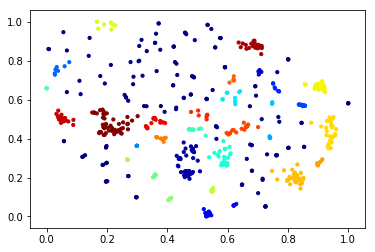

In [282]:
from sklearn.cluster import DBSCAN
from matplotlib import cm
from matplotlib.colors import Normalize

MIN_THESES = 50

degrees = degree_topics[degree_topics["n_theses"] > MIN_THESES]

dbscan = DBSCAN(eps=0.04, min_samples=5)
dbscan.fit(degrees[["x", "y"]])
degrees["cluster"] = dbscan.labels_

# Visualize cluster
cmap = plt.get_cmap('jet')
norm = Normalize(min(dbscan.labels_), max(dbscan.labels_))
plt.scatter(degrees["x"], degrees["y"], 10, cmap(norm(dbscan.labels_)))



In [283]:
# Degrees for each cluster
from IPython.display import display

cluster_sizes = degrees.groupby(["cluster"])["n_theses"].sum().sort_values(ascending=False)
#for cluster in cluster_sizes.index:
#    display(degree_topics[degree_topics["cluster"] == cluster].sort_values("count", ascending=False).head())

In [284]:
cluster_sizes

cluster
-1     18933
 19    14655
 0     14550
 30     8835
 29     8580
 20     5586
 28     4617
 11     4464
 21     3812
 27     3503
 17     2242
 2      1992
 23     1773
 10     1452
 5      1433
 25     1381
 18     1341
 15     1164
 12     1084
 26      971
 16      917
 13      860
 4       758
 3       681
 14      662
 6       636
 9       597
 22      520
 7       501
 24      445
 1       378
 8       336
Name: n_theses, dtype: int64

## Save degree data

In [285]:
degree_topics = degree_topics.rename(columns={'degree_id': '_id', 'degree_name': 'name'})
degree_topics['university'] = degree_topics.apply(lambda x: {'_id': x['university_id'], 'name': x['university_name']}, axis=1)
degree_topics[['_id', 'name', 'x', 'y', 'university']].to_json('../frontend/frontend/app/components/dashboard/degrees_tsne.json', orient='records')